In [152]:
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
#backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from qiskit.visualization import array_to_latex
from qiskit.extensions import UnitaryGate
from qiskit.circuit.random import random_circuit

In [170]:
mat=U(1,1,1)
uni = mat.conj().T@mat
np.allclose(np.eye(4),uni,atol=1e-16)

True

In [5]:
dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

In [200]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b58a80862cd6d4e3f8618d0fb10c85a7415315bcf55dd407e498ce33bdd4709623e266b4fdee952700733135cd2fa847c7bffa65966a4efb0aa2ae6a4ad7b583", overwrite=True)

In [198]:
#MAIN (TROTTER EVO) ANCILLA METHOD

#parameters
n,A,T,G,step=6,1,1,0,4
time = 3
layers = np.array([j for j in range(1,step)])
C = np.zeros((n,len(layers)),dtype=complex)
init='000000'


#specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("simulator_statevector")

#settings job execution
options = Options()
options.execution.shots = 1000
options.optimization_level = 1  # optimization
options.resilience_level = 2  # mitigation

for i in tqdm(range(1,n+1)):
    for k,layer in enumerate(tqdm(layers)):
        qc=QuantumCircuit(n+1)
        #init
        #string = init
        #QuantumCircuit.initialize(qcp,string)
      
        qc.h(0)

        #creation of controlled unitary
        #v_gate = UnitaryGate(X, label='CU') 
        #v_gate = v_gate.control(ctrl_state='1')
        #qc.append(v_gate, [0,n//2])
        qc.cx(0,1)
        #fwd evolution
        qc.barrier(range(n+1))
        qc.barrier(range(n+1))
        #W_j perturbation
        qc.z(i)
        #backwards evolution
        qc.barrier(range(n+1))
        qc.barrier(range(n+1))
        revbwassembler_1(qc,matrix,layer,n)
        #qc.append(v_gate, [0,n//2])
        qc.cx(0,1)
        #generate operator to measure
        op=generate_pauli_1(n,0)
        #runtime
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[qc], observables=[op])
            values = job_sim.result().values
        
        C[i-1,k]=values

 50%|██████████████████████████████████████████▌                                          | 3/6 [00:43<00:43, 14.56s/it]


KeyboardInterrupt: 

In [ ]:
Cnew=np.flipud(np.transpose(np.real(C)))
plt.imshow(Cnew)
plt.xlabel('Sites')
plt.ylabel('Time')
#plt.title('A='+str(A)+' T='+str(T)+' G='+str(G)+' size='+str(n)+' init='+str(init)+' step='+str(step))
plt.colorbar()

In [253]:
#MAIN 2 (1 layer evo) ANCILLA METHOD

n=6

thetas = np.arange(1,10,1)
C = np.zeros((n,len(thetas)),dtype=float)
string='0'*(n+1)
layers = np.array([j for j in range(1,step)])
#specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("simulator_statevector")

#settings job execution
options = Options()
options.execution.shots = 1000
options.optimization_level = 1  # optimization
options.resilience_level = 2  # mitigation

for i in tqdm(range(1,n+1)):
    for k,t in enumerate(tqdm(thetas)):
        qc0 = QuantumCircuit(n+1)
        qc = QuantumCircuit(n+1)
        qcc = QuantumCircuit(n+1)
        circ = QuantumCircuit(n+1)
        final = QuantumCircuit(n+1)
        qc0.h(0)
        qc0.cx(0,1)
        #fwd evolution
        randbwassembler_1(qc,1,6)
        ##W_j perturbation
        qcc.z(i)
        ##backwards evolution
        qcc = qcc.compose(qc.inverse())
        #put circuit together
        circ = qc0.compose(qc.compose(qcc))
        circ.cx(0,1,ctrl_state=0)
        #QuantumCircuit.initialize(final, string)
        final = final.compose(circ) 
        #generate operator to measure
        op=generate_pauli_1(n,0)
        #runtime
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[final], observables=[op])
            values = job_sim.result().values
        
        C[i-1,k]=values

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:35<00:00,  3.90s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:30<00:00, 35.14s/it]


In [249]:
generate_pauli_1(6,0)

SparsePauliOp(['XIIIIII'],
              coeffs=[1.+0.j])

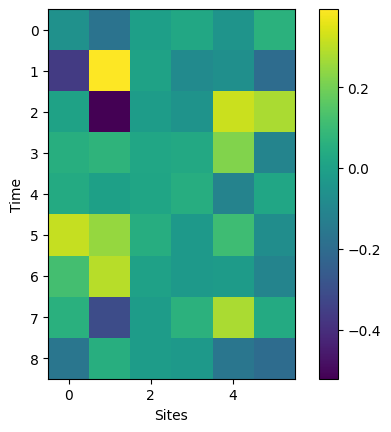

In [254]:
Cnew=np.flipud(np.transpose(C))
plt.imshow(Cnew)
plt.xlabel('Sites')
plt.ylabel('Time')
#plt.title('A='+str(A)+' T='+str(T)+' G='+str(G)+' size='+str(n)+' init='+str(init)+' step='+str(step))
plt.colorbar()

In [ ]:
#saving data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n='+str(n)+' init: '+str(string), 'wb') as file:
      
    # A new file will be created
    pickle.dump(ent_entropy, file)

In [ ]:
#loading data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n=10', 'rb') as file:
    loaded_data = pickle.load(file)

In [252]:
#OTOC
#PLUS PART


def circ(n,A,T,G,step,layers,pos,init):
    matrix = U(A,T/step,G)
    qc=QuantumCircuit(n+1)
    #init
    #string = init
    #QuantumCircuit.initialize(qcp,string)
    X = np.array([[0,1],[1,0]])
    qc.h(0)
    
    
    
    #V_i perturbation +pi/2
    qcp.ry((np.pi/2),n//2,label='V_plus')
    #fwd evolution
    qcp.barrier(range(n))
    qcp.barrier(range(n))
    bwassembler(qcp,matrix,layers,n)
    #W_j perturbation
    qcp.z(pos)
    #backwards evolution
    qcp.barrier(range(n))
    qcp.barrier(range(n))
    revbwassembler(qcp,matrix,layers,n)
    #transpiling
    basis_gates=['cx', 'id', 'rz', 'x', 'sx']
    trans_plus=transpile(qcp, basis_gates=basis_gates, optimization_level=2)
    
    return trans_plus


#define unitary
def U(A,T,G):
    U = np.zeros((4,4), dtype=complex)
    
    U[0,0]=(-1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[0,3]=(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,1]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,2]=(-1+2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,1]=(-1-2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,2]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,0]=-(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,3]=(1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    return(U)

#define BW
def bwassembler_1(qc,matrix,layers,n):
    
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i+1,2*i+2])
            i+=1;
        qc.barrier(range(n+1))
        
        
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                qc.unitary(matrix,[2*j+2,1])
            else:
                qc.unitary(matrix, [2*j+2,2*j+3])
            
            j+=1;
        qc.barrier(range(n+1))
        
        
        m+=1
    qc.barrier(range(n+1))
    return(qc)

#define reversed BW
def revbwassembler_1(qc,matrix,layers,n):
    matrix=matrix.conj().T
    m=0
    while m < layers:
        i=0;j=0;    
        
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                qc.unitary(matrix,[2*j+2,1])
            else:
                qc.unitary(matrix, [2*j+2,2*j+3])
            
            j+=1;
        qc.barrier(range(n+1))
        
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i+1,2*i+2])
            i+=1;
        qc.barrier(range(n+1))
        
        
        m+=1
    qc.barrier(range(n+1))
    return(qc)

#define random BW
def randbwassembler(qc,layers,n):
    
    m=0
    while m < layers:
        i=0;j=0;    
        
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                qc.unitary(unitary_group.rvs(4),[2*j+1,0])
            else:
                qc.unitary(unitary_group.rvs(4), [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        #even layer
        while i < n/2:
            qc.unitary(unitary_group.rvs(4), [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n))
        
        
        m+=1
    qc.barrier(range(n))
    return(qc)
def randbwassembler_1(qc,layers,n):
    
    m=0
    while m < layers:
        i=0;j=0;    
        
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                qc.unitary(unitary_group.rvs(4),[2*j+2,1])
            else:
                qc.unitary(unitary_group.rvs(4), [2*j+2,2*j+3])
            
            j+=1;
        qc.barrier(range(n+1))
        
        #even layer
        while i < n/2:
            qc.unitary(unitary_group.rvs(4), [2*i+1,2*i+2])
            i+=1;
        qc.barrier(range(n+1))
        
        
        m+=1
    qc.barrier(range(n+1))
    return(qc)
#define operators to measure
def generate_pauli(n, j):
    if n <= 0 or j < 0 or  j >= n:
        raise ValueError("Invalid input values")
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i and j
    pauli_str_list = list(pauli_str)
    pauli_str_list[j] = "X"
    pauli_str = "".join(pauli_str_list)
    op = SparsePauliOp(pauli_str, coeffs=[1])
    
    return op

#define operators to measure
def generate_pauli_1(n, j):
    if n <= 0 or j < 0 or  j >= n:
        raise ValueError("Invalid input values")
    
    pauli_str = "I" * (n+1)  # Initialize with n identity operators
    # Set the Z at position i and j
    pauli_str_list = list(pauli_str)
    pauli_str_list[j] = "Y"
    pauli_str = "".join(pauli_str_list)
    op = SparsePauliOp(pauli_str, coeffs=[1])
    
    return op

def prodstaten(n):
    
    X = np.array([[0,1],[1,0]])
    X0 = np.zeros((n,2**n,2**n),dtype = complex)
    
    for i in range(0,n):   
        X0[i]=np.kron(np.kron(np.eye(2**i),X),np.eye(2**(n-i-1)))
    operator = np.eye(2**n)
    for i in range(0,n//2):
        operator = (X0[2*i]+1j*X0[2*i+1])@operator
    return (1/np.sqrt(2**(n//2)))*operator
    
def bell_pair1(qc, a, b):
    
    qc.h(a) # Put qubit a into state |+> or |-> using hadamard gate
    qc.cx(a,b) # CNOT with a as control and b as target
    
def bell_pair4(qc,a,b):
    
    qc.h(a)
    qc.x(b)
    qc.z(a)
    qc.z(b)
    qc.cx(a,b)

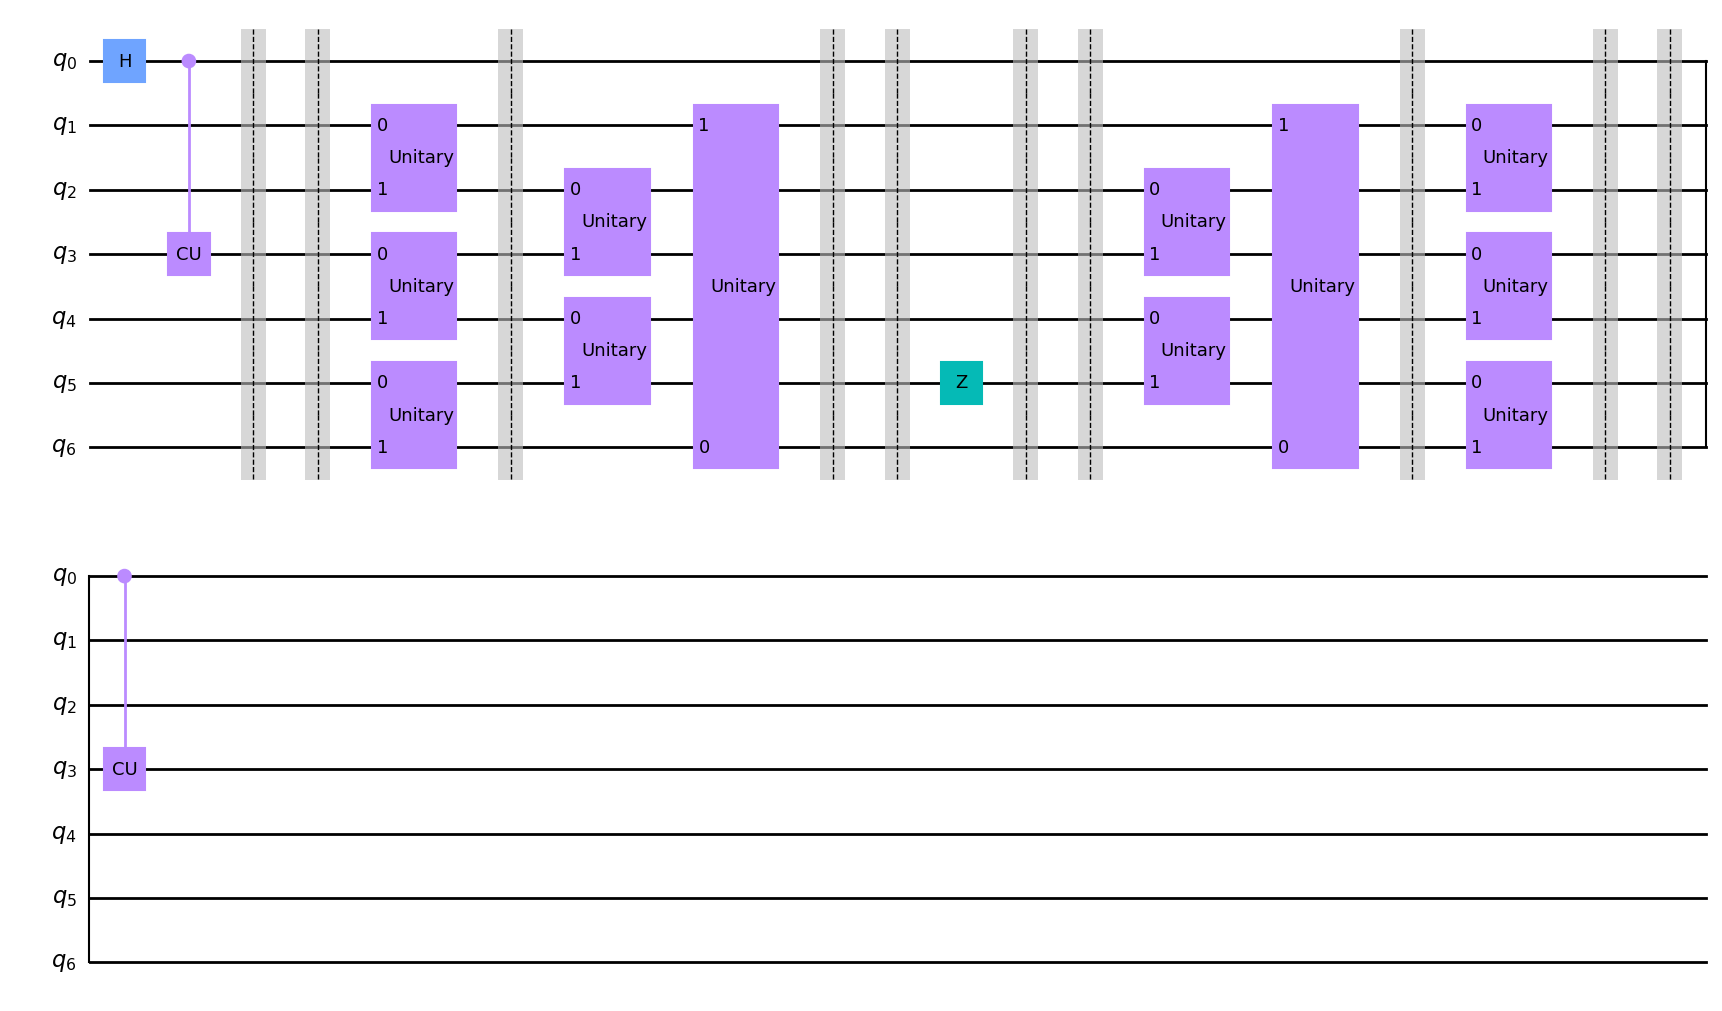

In [107]:
n,A,T,G,step,layers,pos=6,1,1,0,1,1,5
matrix = U(A,T/step,G)
qc=QuantumCircuit(n+1)
#init
#string = init
#QuantumCircuit.initialize(qcp,string)
X = np.array([[0,1],[1,0]])

qc.h(0)
X = np.array([[0,1],[1,0]])
#creation of controlled unitary
v_gate = UnitaryGate(X, label='CU') #this gate will have to be the whole evolution circuit 

v_gate = v_gate.control(ctrl_state='1')
qc.append(v_gate, [0,n//2])

#fwd evolution
qc.barrier(range(n+1))
qc.barrier(range(n+1))
bwassembler_1(qc,matrix,layers,n)
#W_j perturbation
qc.z(pos)
#backwards evolution
qc.barrier(range(n+1))
qc.barrier(range(n+1))
revbwassembler_1(qc,matrix,layers,n)
qc.append(v_gate, [0,n//2])

#transpiling
basis_gates=['cx', 'id', 'rz', 'x', 'sx']
#trans_plus=transpile(qc, basis_gates=basis_gates, optimization_level=2)
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

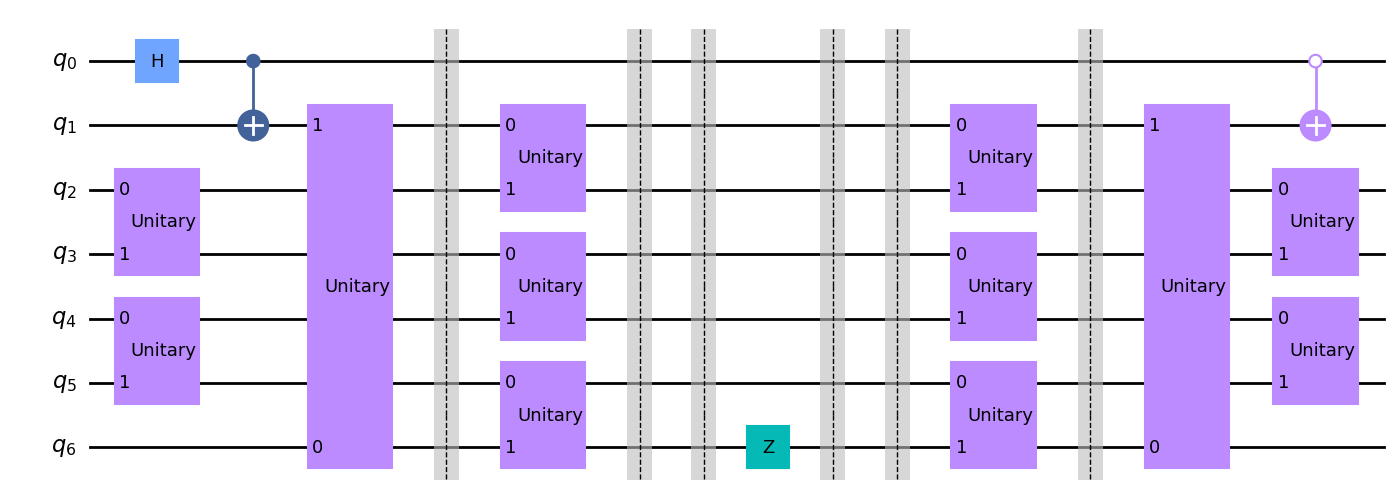

In [246]:
n=6
qc0 = QuantumCircuit(n+1)
qc = QuantumCircuit(n+1)
qcc = QuantumCircuit(n+1)
circ = QuantumCircuit(n+1)
final = QuantumCircuit(n+1)
qc0.h(0)
qc0.cx(0,1)
#fwd evolution
randbwassembler_1(qc,1,6)
##W_j perturbation
qcc.z(i)
##backwards evolution
qcc = qcc.compose(qc.inverse())
#put circuit together
circ = qc0.compose(qc.compose(qcc))
circ.cx(0,1,ctrl_state=0)
#QuantumCircuit.initialize(final, string)
final = final.compose(circ) 

final.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

In [190]:
# Set the initial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**4)
state.draw('latex')

<IPython.core.display.Latex object>

In [192]:
# Evolve the state by the quantum circuit
state = state.evolve(qc)

#draw using latex
state.draw('latex')

#Alternative way of representing in latex
#array_to_latex(state)

<IPython.core.display.Latex object>